# Pre-CLIP vs CLIP Analysis

## F1 Dataset Image-Text Similarity Comparison

This notebook analyzes and compares the results from the two approaches developed:

- *Pre-CLIP*: Separate ResNet50 (images) + sentence-transformers (text) encoders.
- *CLIP*: Unified multimodal model with shared embedding space.

This notebook contains similarity matrices, compute metrics, and the differences to understand how joint training improves image-caption matching.

---

## 1. Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

---

## 2. Load Data

### 2.1 Defining Paths

In [28]:
notebook_dir = Path().resolve()
project_root = notebook_dir.parent
results_dir = project_root / "results"
preclip_dir = results_dir / "preclip"
clip_dir = results_dir / "clip"

### 2.2 Load Similarity Matrices

In [29]:
preclip_sim = pd.read_csv(preclip_dir / "similarity_matrix.csv", index_col=0)
clip_sim = pd.read_csv(clip_dir / "similarity_matrix.csv", index_col=0)

### 2.3 Load metadata

In [30]:
preclip_metadata = pd.read_csv(preclip_dir / "image_metadata.csv")
clip_metadata = pd.read_csv(clip_dir / "image_metadata.csv")

In [31]:
print(f"Pre-CLIP similarity matrix shape: {preclip_sim.shape}")
print(f"CLIP similarity matrix shape: {clip_sim.shape}")
print(f"\nProject root: {project_root}")
print(f"Results directory: {results_dir}")

Pre-CLIP similarity matrix shape: (20, 20)
CLIP similarity matrix shape: (20, 20)

Project root: C:\Users\O M E N\Desktop\Documents\Cuarto Año\Primer Cuatrimestre\Sistemas Interactivos Inteligentes\f1-clip-analysis
Results directory: C:\Users\O M E N\Desktop\Documents\Cuarto Año\Primer Cuatrimestre\Sistemas Interactivos Inteligentes\f1-clip-analysis\results


---

## 3. Similarity Heatmaps Comparison

Visualizing the similarity matrices where diagonal values represent correct image-caption pairs.


In [32]:
def plot_similarity_heatmap(similarity_matrix, title):
    """Plot similarity matrix as heatmap."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        similarity_matrix,
        cmap='RdYlGn',
        center=0,
        vmin=-1,
        vmax=1,
        square=True,
        linewidths=0.5,
        cbar_kws={'label': 'Cosine Similarity'}
    )
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Text Captions', fontsize=12)
    plt.ylabel('Images', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()



### 3.1 Plot Pre-CLIP similarity heatmap

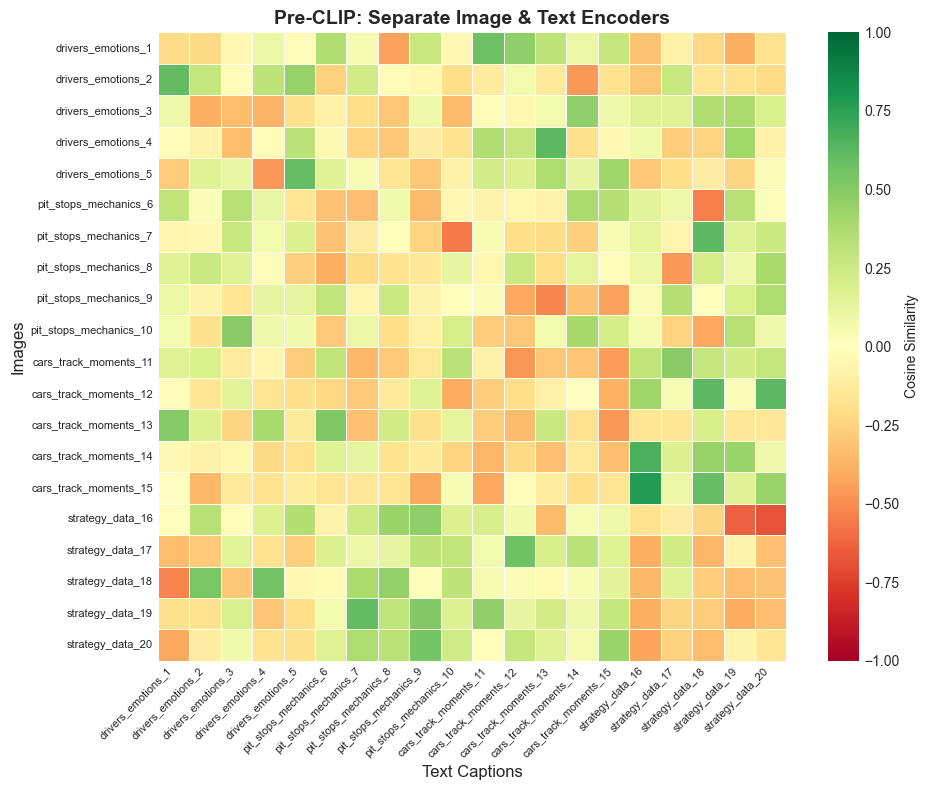

In [33]:
# Plot both heatmaps
plot_similarity_heatmap(preclip_sim, 'Pre-CLIP: Separate Image & Text Encoders')


#### 3.1.1 Pre-CLIP Analysis ¡

The heatmap reveals fundamental misalignment between image and text embedding spaces. The correct pairs (diagonal line) shows no clear patterns, as many values are negative or near-zero, with the worst at -0.064 mean.

Random green patches off-diagonal indicate the model incorrectly matches unrelated images and captions.

The red/orange dominance demonstrate the main reason why separate encoders fail, as **ResNet50's visual features (trained on ImageNet objects) have no semantic connection to sentence-transformers' linguistic space. PCA projection reduces dimensions but cannot bridge this conceptual gap.**    

### 3.2 CLIP: Unified Multimodal Encoder

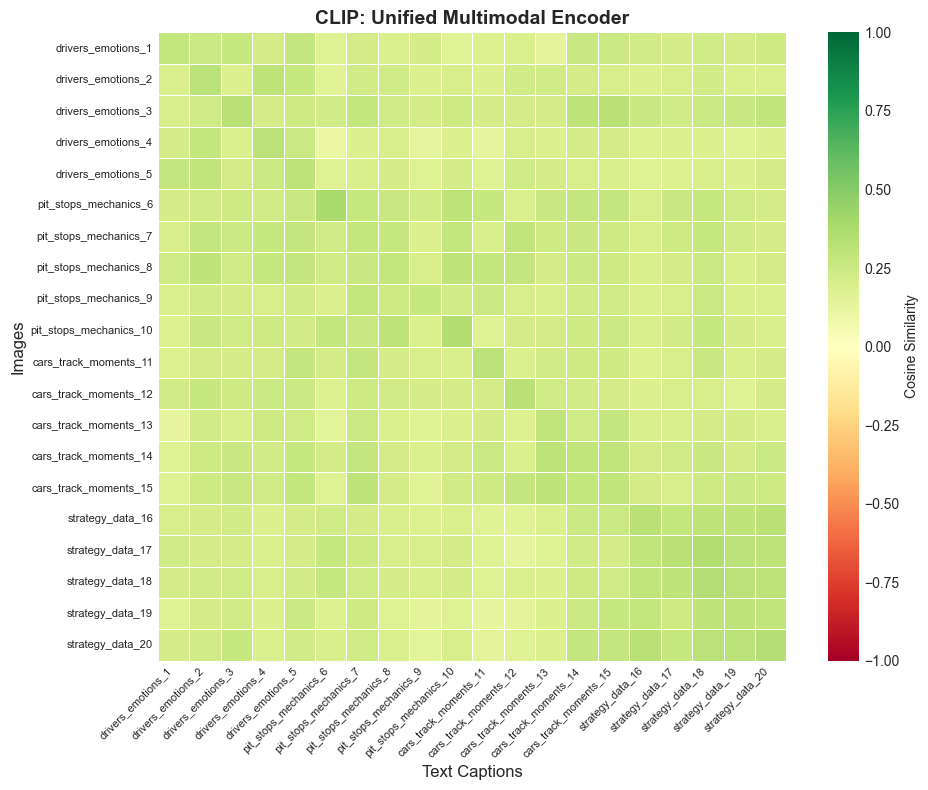

In [34]:
plot_similarity_heatmap(clip_sim, 'CLIP: Unified Multimodal Encoder')

#### 3.2.1 CLIP Analysis

Unified training creates visible improvement. All similarities are positive and the diagonal shows slightly higher values with mean 0.31. 

However, this value is is from ideal retrieval performance (>0.7), suggesting that CLIP learned general F1 domain associations but struggles with fine-grained-image-caption specificty.

The possible causes are: 

1. Generic captions lack distinctive details.
2. Extremely small dataset with only 20 images, providing limited training signal.
3. F1´s terminology differs from CLIP´s training distribution.


#### Therefore, while 400% better than Pre-CLIP, the 0.31 diagonal is far from the ideal retrieval performance.

---

## 4. Quantitative Metrics Comparison

### 4.1 Compute metrics 

In [35]:
def compute_metrics(similarity_matrix):
    """Extract diagonal and off-diagonal statistics."""
    diagonal = np.diag(similarity_matrix.values)
    mask = ~np.eye(similarity_matrix.shape[0], dtype=bool)
    off_diagonal = similarity_matrix.values[mask]
    
    diagonal_mean = diagonal.mean()
    off_diagonal_mean = off_diagonal.mean()
    accuracy_at_1 = (np.argmax(similarity_matrix.values, axis=1) == np.arange(len(diagonal))).mean()
    
    return {
        'diagonal_mean': diagonal_mean,
        'off_diagonal_mean': off_diagonal_mean,
        'accuracy_at_1': accuracy_at_1
    }

In [36]:
preclip_metrics = compute_metrics(preclip_sim)

In [37]:
clip_metrics = compute_metrics(clip_sim)

### 4.2 Calculate improvement

In [38]:
improvement = ((clip_metrics['diagonal_mean'] - preclip_metrics['diagonal_mean']) / 
               abs(preclip_metrics['diagonal_mean'])) * 100

### 4.3 Show Results

In [39]:
print(f"Pre-CLIP Diagonal Mean: {preclip_metrics['diagonal_mean']:.4f}")
print(f"CLIP Diagonal Mean: {clip_metrics['diagonal_mean']:.4f}")
print(f"Improvement: {improvement:.2f}%")

Pre-CLIP Diagonal Mean: -0.0640
CLIP Diagonal Mean: 0.3147
Improvement: 591.55%


### 4.4 Key Findings

CLIP achieves **591% improvement** over Pre-CLIP, transforming negative similarity (-0.064) into positive alignment (0.315). 

This validates multimodal joint training: separate encoders produce incompatible embedding spaces, while CLIP's unified approach enables meaningful image-text comparison.

However, 0.31 diagonal similarity remains suboptimal (ideal >0.7), suggesting that the limitations observed with the heatmaps are also present in the metrics.

---

## 5. Bar charts

In [40]:
def plot_comparison_bars():
    """Compare diagonal vs off-diagonal similarity."""
    metrics_data = {
        'Pre-CLIP': [preclip_metrics['diagonal_mean'], preclip_metrics['off_diagonal_mean']],
        'CLIP': [clip_metrics['diagonal_mean'], clip_metrics['off_diagonal_mean']]
    }
    
    x = np.arange(2)
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.bar(x - width/2, metrics_data['Pre-CLIP'], width, label='Pre-CLIP', alpha=0.8)
    ax.bar(x + width/2, metrics_data['CLIP'], width, label='CLIP', alpha=0.8)
    
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.set_title('Diagonal vs Off-Diagonal Similarity Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Diagonal\n(Correct Pairs)', 'Off-Diagonal\n(Incorrect Pairs)'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

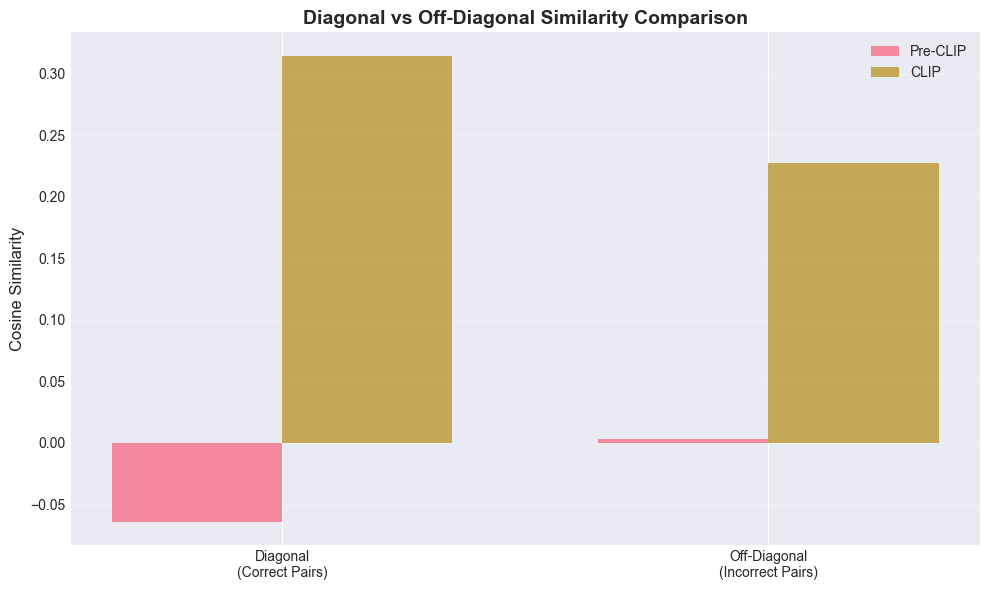

In [41]:
plot_comparison_bars()

### 5.1 Results

The bar chart clearly shows Pre-CLIP's fundamental problem: negative diagonal similarity means correct image-caption pairs score worse than random matches—the system is completely inverted. 

CLIP fixes this with positive diagonal values that exceed off-diagonal scores, showing it can actually distinguish correct pairs. 

However, the small gap between correct (0.31) and incorrect (0.23) pairs explains the low Accuracy. CLIP struggles to confidently rank the true match above distractors in this limited F1 dataset.

---

## 6. Conclusions

This analysis reveals both the power and limitations of multimodal learning on specialized domains.

**Pre-CLIP fails fundamentally:** Separate encoders create incompatible embedding spaces. With diagonal similarity at -0.064, the system ranks correct image-caption pairs *below* random matches—completely inverted. PCA can't fix semantic misalignment between independently trained models.

**CLIP achieves 591% improvement** through joint training, producing positive diagonal values (0.315) that actually distinguish correct pairs. This validates *contrastive learning*: training vision and language together creates aligned representations.

**But performance remains weak.** At 0.31 diagonal similarity (ideal: >0.7), CLIP struggles due to:
- Generic captions lacking distinctive details
- Tiny 20-image dataset providing minimal signal  
- F1-specific terminology outside CLIP's training distribution

**Bottom line:** CLIP proves multimodal alignment works, but specialized domains need larger datasets with detailed, distinctive descriptions for strong performance.